## Load Base

In [1]:
from glob import glob
import os
from skimage.io import imread

def load_images(DATABASE_PATH, classes, qtd_imagens=1300):
    database = []
    
    for classe in classes:
        IMAGES_PATH = classe + '/images'

        IMAGES_NAME = glob(os.path.join(DATABASE_PATH, IMAGES_PATH, '*.png'))
    
        imagens = []
        for IMAGE_NAME in IMAGES_NAME[0:qtd_imagens]:
            imagens.append(imread(IMAGE_NAME, as_gray=True))
            
        database.append(imagens)
    
    return database

In [2]:
DATABASE_PATH = '../archive/COVID-19_Radiography_Dataset/'
classes = ['Normal', 'COVID', 'Viral Pneumonia']
database = load_images(DATABASE_PATH, classes, qtd_imagens=1300)

In [3]:
len(database[0]), len(database[1]), len(database[2])

(1300, 1300, 1300)

## Pre Processing

In [8]:
from skimage.filters import laplace
from matplotlib import pyplot as plt

In [17]:
img = database[0][0]
img_laplace = laplace(img)

img_detalhada = img + (-1 * img_laplace)

img_detalhada[img_detalhada < 0] = 0
img_detalhada[img_detalhada > 255] = 255


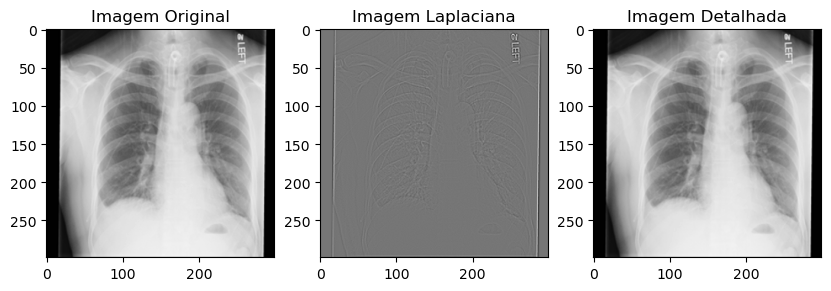

In [19]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Imagem Original')
fig.add_subplot(1, 3, 2)
plt.imshow(img_laplace, cmap='gray')
plt.title('Imagem Laplaciana')
fig.add_subplot(1, 3, 3)
plt.imshow(img_detalhada, cmap='gray')
plt.title('Imagem Detalhada');

In [20]:
def make_laplace_database(database):
    laplace_database = []
    for classe in database:
        imagens = []
        for img in classe:
            img_laplace = laplace(img)
            img_detalhada = img + (-1 * img_laplace)
            img_detalhada[img_detalhada < 0] = 0
            img_detalhada[img_detalhada > 255] = 255
            imagens.append(img_detalhada)
        laplace_database.append(imagens)
    return laplace_database

In [21]:
new_database = make_laplace_database(database)

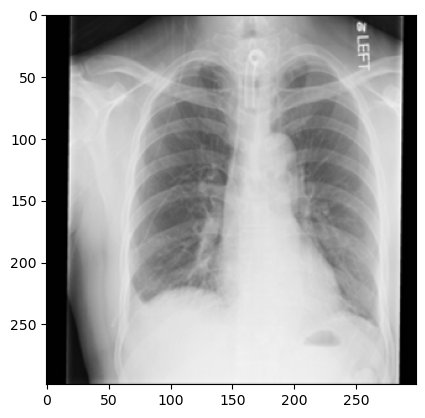

In [22]:
plt.imshow(new_database[0][0], cmap='gray');

## Segmentation

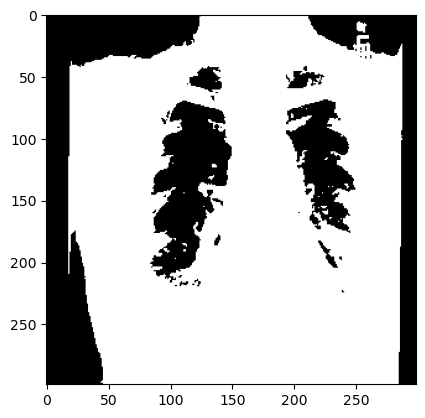

In [62]:
from sklearn.cluster import KMeans
def make_kmeans(img):
    kmeans = KMeans(n_clusters=2, random_state=0).fit(img.reshape(-1, 1))
    return kmeans.predict(img.reshape(-1, 1)).reshape(img.shape)
plt.imshow(make_kmeans(img), cmap='gray');

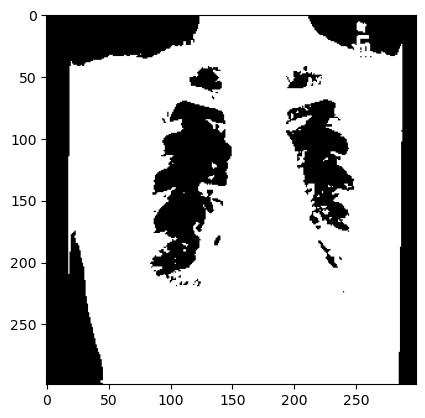

In [63]:
from skimage.filters import threshold_otsu
def make_otsu(img):
    otsu = threshold_otsu(img)
    otsu_img = img > otsu
    return otsu_img
plt.imshow(make_otsu(img), cmap='gray')

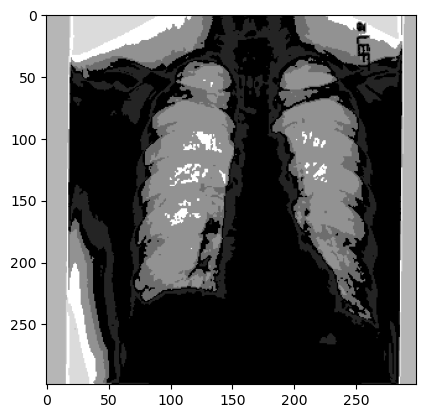

In [64]:
from sklearn.cluster import MeanShift, estimate_bandwidth
def make_meanshift(img):
    bandwidth = estimate_bandwidth(img.reshape(-1, 1), quantile=0.12, n_samples=100)    
    ms = MeanShift(bandwidth = bandwidth, bin_seeding=True, n_jobs = -1)
    ms.fit(img.reshape(-1, 1))
    labels = ms.labels_
    labels[labels == 2] = 0
    return labels.reshape(img.shape)
plt.imshow(make_meanshift(img), cmap='gray');

In [60]:
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed

def segment_image(img, method='felzenszwalb'):
    if method == 'felzenszwalb':
        segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
        return segments_fz
    elif method == 'slic':
        segments_slic = slic(img, n_segments=100, compactness=10, sigma=1)
        return segments_slic
    elif method == 'quickshift':
        segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
        return segments_quick
    elif method == 'watershed':
        segments_watershed = watershed(img, markers=10, compactness=0.001)
        return segments_watershed
    else:
        print('Método não encontrado')
        return None

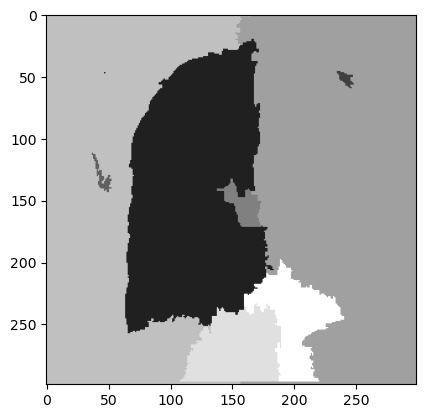

In [61]:
plt.imshow(segment_image(img, method='watershed'), cmap='gray');

In [65]:
def make_segmentation_database(database, function):
    segmentation_database = []
    for classe in database:
        imagens = []
        for img in classe:
            imagens.append(function(img))
        segmentation_database.append(imagens)
    return segmentation_database

In [66]:
segmentation_database = make_segmentation_database(database, make_otsu)

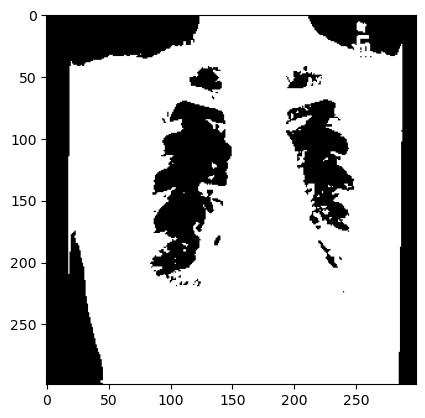

In [67]:
plt.imshow(segmentation_database[0][0], cmap='gray');

## Descriptors

First

In [85]:
import numpy as np
from scipy.stats import entropy, skew, kurtosis

def energy(x):
    return np.sum(np.power(x, 2))

def descritor_histograma(imagem):
    frequencias, _ = np.histogram(imagem, bins=256, density=True)

    media = np.mean(frequencias)

    var = np.var(frequencias)

    sk = skew(frequencias)

    kur = kurtosis(frequencias)

    ener = energy(frequencias)
    
    entr = entropy(frequencias)

    return [media,var,sk,kur,ener,entr]

In [69]:
print(descritor_histograma(img))

[0.003952569169960474, 3.64354707321027e-05, 9.700923939933757, 126.78428986444192, 0.01332691808650873, 4.990346805620715]


In [86]:
def matrix_descritors(database, function = None):
    x = []
    y = []
    for classe, images in enumerate(database):
        for image in images:
            x.append(function(image))
            y.append(classe)

    return x,y

In [87]:
x, y = matrix_descritors(database, function=descritor_histograma)

In [89]:
print(x[0])

[0.003952569169960474, 3.64354707321027e-05, 9.700923939933757, 126.78428986444192, 0.01332691808650873, 4.990346805620715]


Second

In [90]:
from skimage.feature import graycomatrix, graycoprops
glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
contrast = graycoprops(glcm, 'contrast')
dissimilarity = graycoprops(glcm, 'dissimilarity')
homogeneity = graycoprops(glcm, 'homogeneity')
ASM = graycoprops(glcm, 'ASM')
energy = graycoprops(glcm, 'energy')
correlation = graycoprops(glcm, 'correlation')

print(contrast, dissimilarity, homogeneity, ASM, energy, correlation)

[[134.91692667]] [[3.81697381]] [[0.42193441]] [[0.00692432]] [[0.0832125]] [[0.98619833]]


In [91]:
def to_bool(img):
    return img > 0

In [98]:
def make_graycomatrix(img):
    glcm = graycomatrix(to_bool(img), distances=[1], angles=[0], levels=2, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    ASM = graycoprops(glcm, 'ASM')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')
    return [contrast[0][0], dissimilarity[0][0], homogeneity[0][0], ASM[0][0], energy[0][0], correlation[0][0]]

In [99]:
x, y = matrix_descritors(database, make_graycomatrix)

In [100]:
print(x[0])

[0.013400372606675495, 0.013400372606675495, 0.9932998136966622, 0.9705718857483214, 0.9851760684001217, 0.1731896744032666]


## Classification

In [125]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score

In [131]:
metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

In [111]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

First

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [112]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)
print(accuracy_score(y_test, pred))

0.5256410256410257


In [132]:
scores = cross_validate(rf, x,y, cv=10, scoring=metrics)

In [128]:
scores

{'fit_time': array([0.74751878, 0.70608306, 0.72381568, 0.7392838 , 0.73085093,
        0.76886106, 0.69554114, 0.67365742, 0.71940064, 0.76093531]),
 'score_time': array([0.03048086, 0.02985048, 0.03035355, 0.03043866, 0.0299027 ,
        0.03047848, 0.02822161, 0.03057098, 0.02983046, 0.0464499 ]),
 'test_accuracy': array([0.55897436, 0.58461538, 0.57179487, 0.53076923, 0.52564103,
        0.53589744, 0.52051282, 0.58717949, 0.55384615, 0.57948718]),
 'test_precision_weighted': array([0.55712416, 0.59082485, 0.57142543, 0.53202519, 0.52573737,
        0.53841745, 0.52367126, 0.5899531 , 0.56005118, 0.58514285]),
 'test_recall_weighted': array([0.55897436, 0.58461538, 0.57179487, 0.53076923, 0.52564103,
        0.53589744, 0.52051282, 0.58717949, 0.55384615, 0.57948718]),
 'test_f1_weighted': array([0.55683923, 0.58415183, 0.56824345, 0.53017519, 0.52023832,
        0.53656723, 0.52105839, 0.58786916, 0.55191235, 0.57920855])}

In [120]:
print('Acuracia: {} (+/- {})'.format(scores['test_accuracy'].mean(), scores['test_accuracy'].std()) )
print('Precision: {} (+/- {})'.format(scores['test_precision_weighted'].mean(), scores['test_precision_weighted'].std()) )
print('Recall: {} (+/- {})'.format(scores['test_recall_weighted'].mean(), scores['test_recall_weighted'].std()) )
print('F1: {} (+/- {})'.format(scores['test_f1_weighted'].mean(), scores['test_f1_weighted'].std()) )
print('Jaccard: {} (+/- {})'.format(scores['test_jaccard'].mean(), scores['test_jaccard'].std()) )

Acuracia: 0.5548717948717948 (+/- 0.024113472708735897)
Precision: 0.5574372847929293 (+/- 0.025089365665584916)
Recall: 0.5548717948717948 (+/- 0.024113472708735897)
F1: 0.5536263699095529 (+/- 0.024499279754279093)


Second

In [121]:
svc = SVC(kernel='linear', random_state=42)
svc.fit(x_train, y_train)
pred = svc.predict(x_test)
print(accuracy_score(y_test, pred))

0.43333333333333335


In [122]:
scores = cross_validate(svc, x,y, cv=10, scoring=metrics)

In [123]:
scores

{'fit_time': array([0.96340847, 0.92515612, 0.91995978, 0.95958424, 0.92541742,
        0.94548178, 0.8531878 , 0.85964012, 0.93257689, 0.98377562]),
 'score_time': array([0.05502987, 0.04811883, 0.04775023, 0.05060458, 0.07293415,
        0.04864097, 0.0494523 , 0.05610776, 0.04882312, 0.04856706]),
 'test_accuracy': array([0.51025641, 0.42307692, 0.45384615, 0.44358974, 0.42051282,
        0.4025641 , 0.48205128, 0.48461538, 0.41025641, 0.43076923]),
 'test_precision_weighted': array([0.51452685, 0.46798815, 0.47724126, 0.4881062 , 0.42717803,
        0.40134555, 0.48970182, 0.48724513, 0.5161039 , 0.44104426]),
 'test_recall_weighted': array([0.51025641, 0.42307692, 0.45384615, 0.44358974, 0.42051282,
        0.4025641 , 0.48205128, 0.48461538, 0.41025641, 0.43076923]),
 'test_f1_weighted': array([0.50550385, 0.37762967, 0.41501406, 0.38508971, 0.41259347,
        0.37969513, 0.47269002, 0.47832988, 0.3566044 , 0.42109926])}

In [124]:
print('Acuracia: {} (+/- {})'.format(scores['test_accuracy'].mean(), scores['test_accuracy'].std()) )
print('Precision: {} (+/- {})'.format(scores['test_precision_weighted'].mean(), scores['test_precision_weighted'].std()) )
print('Recall: {} (+/- {})'.format(scores['test_recall_weighted'].mean(), scores['test_recall_weighted'].std()) )
print('F1: {} (+/- {})'.format(scores['test_f1_weighted'].mean(), scores['test_f1_weighted'].std()) )

Acuracia: 0.4461538461538462 (+/- 0.03399733137224045)
Precision: 0.47104811326210816 (+/- 0.03542977314055483)
Recall: 0.4461538461538462 (+/- 0.03399733137224045)
F1: 0.4204249441782946 (+/- 0.04714456126288913)
